In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import keras
import pandas as pd
%matplotlib inline
data =np.load("ps4_trainvalid_images.npy")
labels=pd.read_csv('ps4_trainvalid_labels.csv')

In [10]:
data.shape

(13260, 64, 64, 1)

In [32]:
labels['Label'].value_counts()

0    10506
1     2372
2      382
Name: Label, dtype: int64

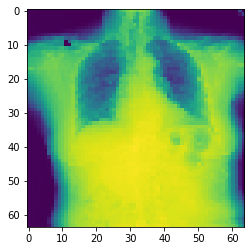

In [50]:
plt.imshow(data[1])

In [51]:
train_x,test_x,train_y, test_y=sklearn.model_selection.train_test_split(data,labels,train_size=0.8,random_state=42)

In [72]:
train_x.shape,train_x.dtype

((10608, 64, 64, 1), dtype('float64'))

In [55]:
train_y.iloc[0]

Id       2484
Label       2
Name: 2484, dtype: int64

In [68]:
train_y['Label'].shape

(10608,)

In [71]:
train_x=train_x.reshape(-1,64,64,1)/255.0
test_x=test_x.reshape(-1,64,64,1)/255.0


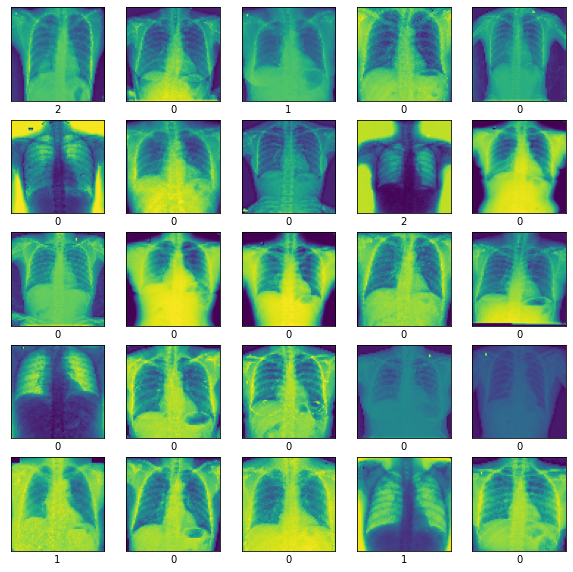

In [76]:
class_names=['0','1','2']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i])
    plt.xlabel(class_names[train_y['Label'].iloc[i]])
plt.show()

In [97]:
lenet5=tf.keras.Sequential([tf.keras.layers.Conv2D(filters=20,kernel_size=(5,5),activation='relu',input_shape=(64,64,1)),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid'),
                          tf.keras.layers.Conv2D(filters=50,kernel_size=(5,5),activation='relu'),
                              tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(500,activation='relu'),
                          tf.keras.layers.Dense(3,activation='softmax')])
lenet5.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
lenet5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 50)        25050     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8450)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               4225500   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                

In [98]:
lenet5.fit(train_x,train_y['Label'],epochs=20,validation_split=0.2)

Epoch 1/20
266/266 [==============================] - 26s 95ms/step - loss: 0.6413 - accuracy: 0.7772 - val_loss: 0.5378 - val_accuracy: 0.7974
Epoch 2/20
266/266 [==============================] - 25s 95ms/step - loss: 0.5251 - accuracy: 0.7973 - val_loss: 0.5157 - val_accuracy: 0.7950
Epoch 3/20
266/266 [==============================] - 23s 87ms/step - loss: 0.4984 - accuracy: 0.7979 - val_loss: 0.4603 - val_accuracy: 0.8153
Epoch 4/20
266/266 [==============================] - 26s 96ms/step - loss: 0.4296 - accuracy: 0.8357 - val_loss: 0.4605 - val_accuracy: 0.8303
Epoch 5/20
266/266 [==============================] - 25s 92ms/step - loss: 0.4284 - accuracy: 0.8409 - val_loss: 0.3819 - val_accuracy: 0.8633
Epoch 6/20
266/266 [==============================] - 26s 98ms/step - loss: 0.3714 - accuracy: 0.8636 - val_loss: 0.3638 - val_accuracy: 0.8746
Epoch 7/20
266/266 [==============================] - 27s 102ms/step - loss: 0.3623 - accuracy: 0.8676 - val_loss: 0.3693 - val_accuracy